# Prague Pedestrian Accessibility

### Installing packages

I will use OSMnx - a Python package by Geoff Boeing to work with street networks: retrieve, construct, analyze, and visualize street networks (and more) from OpenStreetMap.
<a>https://github.com/gboeing/osmnx</a>.

In [7]:
!conda install -c conda-forge/label/gcc7 osmnx

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - osmnx


The following packages will be UPDATED:

    krb5:            1.16.1-h173b8e3_7                   --> 1.16.2-hc83ff2d_1000      conda-forge/label/gcc7
    libarchive:      3.3.3-h5d8350f_5                    --> 3.3.3-ha149a29_1000       conda-forge/label/gcc7
    thrift-cpp:      0.11.0-h02b749d_3                   --> 0.11.0-h23e226f_1003      conda-forge/label/gcc7

The following packages will be DOWNGRADED:

    ca-certificates: 2019.9.11-hecc5488_0    conda-forge --> 2018.10.15-ha4d7672_0     conda-forge/label/gcc7
    certifi:         2019.9.11-py36_0        conda-forge --> 2018.8.24-py36_1001       conda-forge/label/gcc7
    cryptography:    2.7-py36h72c5cf5_0      conda-forge --> 2.3.1-py36hb7f436b_1000   conda-forge/label/gcc7
    curl:            7.65.3-hbc83047_0                   --> 7.63.0-h646f8bb_1000      conda-forge/label/gcc7
    fre

Installing gecoder. A simple and consistent geocoding library

In [4]:
!conda install -c conda-forge geocoder

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    psycopg2-2.8.2             |   py36h72c5cf5_0         163 KB  conda-forge
    freetds-1.1rc3             |       h4fe99da_0         2.4 MB  conda-forge
    libcurl-7.65.3             |       h20c2e04_0         588 KB
    libgdal-2.2.2              |       h804cdde_1        16.1 MB
    pyproj-1.9.5.1             |py36h2944ce7_1006          64 KB  conda-forge
    h5py-2.8.0                 |   py36h470a237_0         3.7 MB  conda-forge
    libssh2-1.8.2              |       h22169c7_2         257 KB  conda-forge
    kealib-1.4.8               |       hfc679d8_0         173 KB  conda-forge
    libevent-2.1.10            |       h72c5cf5_0         1.3 MB  conda-forge
    ratelim-0.1.6              |        

Importing all nessecary libraries

In [58]:
#import osmnx as ox
import io
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import folium
import geocoder
import json
import urllib.request
import requests
from pandas.io.json import json_normalize

## Data acquisition and cleaning

As main data source I sellected <a>http://opendata.praha.eu</a>.  This is a big database of data of different types amd it contains data from different fileds: transport, society, ecology, population e.t.c  
This data sets were mainly colleted and structured by Prague Institute of Planning and Development <a>www.iprpraha.cz</a> For my project I mainly intrested in:
* Shape and location of Prague administrative districs
* Districts population
* Geo location different types of social infrastructure 

First step is to determine the shape and location of the administrative disctrics of Prague.

In [12]:
mestky_casty_url = 'http://opendata.iprpraha.cz/CUR/DTMP/TMMESTSKECASTI_P/S_JTSK/TMMESTSKECASTI_P.json'
results = requests.get(mestky_casty_url).json(encoding = "ISO 8859-2")
mestky_casty = json_normalize(results['features']) 
mestky_casty.head()

,geometry.coordinates,geometry.type,properties.DAT_VZNIK,properties.DAT_ZMENA,properties.ID,properties.ID_POSKYT,properties.KOD_MC,properties.KOD_MO,properties.KOD_SO,properties.NAZEV_1,properties.NAZEV_MC,properties.OBJECTID,properties.PLOCHA,properties.POSKYT,properties.STAV_ZMENA,properties.Shape_Area,properties.Shape_Length,properties.TID_TMMESTSKECASTI_P,type
0,"[[[-733714.400049571, -1035864.4000071399], [-...",Polygon,20181106141412,20190423111436,25,43,547310,94,221,Čakovice,Praha-Čakovice,1,10183715.88,HMP-IPR,U,1.018372e+07,18510.070839,25,Feature
1,"[[[-752038.7200328708, -1042852.1399567612], [...",Polygon,20181106141412,20181106164427,52,43,547174,60,213,Praha 17,Praha 17,2,3253142.41,HMP-IPR,U,3.253142e+06,7936.181071,52,Feature
2,"[[[-739798.2500479966, -1054096.0200056992], [...",Polygon,20181009145125,20190821104230,19,43,547051,43,124,Libuš,Praha-Libuš,3,5234736.54,HMP-IPR,U,5.234737e+06,17091.236497,19,Feature
3,"[[[-735474.7199597731, -1034591.3400167227], [...",Polygon,20170817145228,20170818091113,35,43,538124,86,86,Březiněves,Praha-Březiněves,4,3380681.90,HMP-IPR,U,3.380682e+06,10544.898980,35,Feature
4,"[[[-741896.6200025454, -1045445.5300298147], [...",Polygon,20180910110223,20180910113234,30,43,500089,27,27,Praha 2,Praha 2,5,4184937.95,HMP-IPR,U,4.184938e+06,11648.078551,30,Feature


In [26]:
mestky_casty.shape

(57, 19)

In [49]:
geo_unique = np.array(mestky_casty['properties.NAZEV_MC'].apply(lambda x: x.lower()).unique())
geo_unique

array(['praha-čakovice', 'praha 17', 'praha-libuš', 'praha-březiněves',
       'praha 2', 'praha 1', 'praha 11', 'praha-zbraslav', 'praha 15',
       'praha 4', 'praha 5', 'praha 20', 'praha-dolní měcholupy',
       'praha 6', 'praha 9', 'praha 10', 'praha 14', 'praha 12',
       'praha-kolovraty', 'praha-újezd', 'praha 13', 'praha-řeporyje',
       'praha-suchdol', 'praha-ďáblice', 'praha-šeberov',
       'praha-dolní chabry', 'praha 19', 'praha-koloděje',
       'praha-satalice', 'praha-petrovice', 'praha 3',
       'praha-velká chuchle', 'praha-dolní počernice',
       'praha-přední kopanina', 'praha-královice', 'praha-kunratice',
       'praha-slivenec', 'praha-vinoř', 'praha-lochkov', 'praha-nebušice',
       'praha-benice', 'praha 18', 'praha-křeslice', 'praha-troja',
       'praha 7', 'praha-nedvězí', 'praha 21', 'praha-běchovice',
       'praha-štěrboholy', 'praha-dubeč', 'praha-lysolaje',
       'praha-lipence', 'praha 8', 'praha 22', 'praha-zličín', 'praha 16',
       'praha-

Districts population

In [63]:
url_population =  'https://www.czso.cz/documents/10180/25233177/sldb_zv.csv'
df_population = pd.read_csv(url_population,encoding = "ISO 8859-2")
df_population.head()

,typuz_naz,nazev,uzcis,uzkod,u01,u02,u03,u04,u05,u06,u07,u08,u09,u10,u11
0,kraj,Hlavní město Praha,100,3018,1268796.0,613738.0,655058.0,153622.0,908321.0,201029.0,644643.0,600730.0,92927.0,542168.0,579509.0
1,kraj,Středočeský kraj,100,3026,1289211.0,637252.0,651959.0,199300.0,895024.0,190911.0,639851.0,587539.0,286780.0,482860.0,523045.0
2,kraj,Jihočeský kraj,100,3034,628336.0,308296.0,320040.0,91119.0,435187.0,100000.0,307130.0,280844.0,123048.0,247608.0,262692.0
3,kraj,Plzeňský kraj,100,3042,570401.0,282137.0,288264.0,79469.0,396468.0,92734.0,278674.0,255278.0,105835.0,226298.0,242397.0
4,kraj,Karlovarský kraj,100,3051,295595.0,145483.0,150112.0,42159.0,207480.0,44538.0,139871.0,123100.0,39845.0,119403.0,128904.0


Cleaning population data set. For my project only make sence data 

In [64]:
df_population = df_population[(df_population.uzcis == 44)& (df_population.nazev.str.find('Praha') != -1)][['nazev','u01','u04', 'u05', 'u06']]
df_population.rename(columns={'nazev':'Name','u01':'Total', 'u04':'Kids', 'u05':'Middle', 'u06':'Senior'}, inplace = True)
df_population['Name'] = df_population['Name'].map(lambda x: x.lower())
df_population.shape

(57, 5)

Quick analizing of distrcit population

In [61]:
population_unique = df_population['Name'].unique()
population_unique

array(['praha 1', 'praha 2', 'praha 3', 'praha 4', 'praha 5', 'praha 6',
       'praha 7', 'praha 8', 'praha 9', 'praha 10', 'praha-běchovice',
       'praha-benice', 'praha-březiněves', 'praha-dolní počernice',
       'praha-dubeč', 'praha 20', 'praha-klánovice', 'praha-koloděje',
       'praha-kolovraty', 'praha-královice', 'praha-křeslice',
       'praha-nedvězí', 'praha-satalice', 'praha 22', 'praha 21',
       'praha-vinoř', 'praha-lipence', 'praha-lochkov',
       'praha-přední kopanina', 'praha 16', 'praha-řeporyje',
       'praha-slivenec', 'praha 13', 'praha-\x8aeberov', 'praha-újezd',
       'praha-zbraslav', 'praha-zličín', 'praha 11', 'praha-kunratice',
       'praha-libu\x9a', 'praha 12', 'praha-velká chuchle',
       'praha-lysolaje', 'praha-nebu\x9aice', 'praha 17', 'praha-suchdol',
       'praha-ďáblice', 'praha-dolní chabry', 'praha-čakovice',
       'praha-troja', 'praha 19', 'praha 14', 'praha-dolní měcholupy',
       'praha 15', 'praha-petrovice', 'praha-\x8atěrboho

Checking the difference between to datasets

In [65]:
districts_diff_geo = list(set(geo_unique)-set(population_unique))
districts_diff_geo

['praha-štěrboholy', 'praha-nebušice', 'praha-šeberov', 'praha-libuš']

In [66]:
districts_diff_pop = list(set(population_unique)-set(geo_unique))
districts_diff_pop

['praha-libu\x9a',
 'praha-\x8aeberov',
 'praha-nebu\x9aice',
 'praha-\x8atěrboholy']

Population data set has encoding errors. Lets fix it

In [67]:
df_population.loc[df_population.Name == 'praha-libu\x9a'] = 'praha-libuš'
df_population.loc[df_population.Name == 'praha-\x8aeberov'] = 'praha-šeberov'
df_population.loc[df_population.Name == 'praha-nebu\x9aice'] = 'praha-nebušice'
df_population.loc[df_population.Name == 'praha-\x8atěrboholy'] = 'praha-štěrboholy'

In [70]:
population_unique = df_population['Name'].unique()
districts_diff_pop = list(set(population_unique)-set(geo_unique))
districts_diff_pop

[]

In [44]:
result = []

result.append([
    v['properties']['ID'],
    v['properties']['NAZEV_MC'],
    v['geometry']['coordinates'],
    v['properties']['PLOCHA']] for v in results['features'])
    
df_prague = pd.DataFrame([item for result in result for item in result])
df_prague.columns = ['ID', 'Neigborouhood', 'Geometry', 'Area']

In [45]:
df_prague.sort_values('Neigborouhood', inplace = True)

In [46]:
dict_coordinates = {}
for index, row in df_prague.iterrows():
    g = geocoder.arcgis(row['Neigborouhood'])
    lat = g.json['lat']
    lng = g.json['lng']
    dict_coordinates[row['Neigborouhood']] = [lat, lng]
    
df_prague['latitude'] = 0.0
df_prague['longitude'] = 0.0
for k, v in dict_coordinates.items():
    df_prague.loc[df_prague.Neigborouhood == k,'latitude']=v[0]
    df_prague.loc[df_prague.Neigborouhood == k,'longitude']=v[1]
    
df_prague.head()

,ID,Neigborouhood,Geometry,Area,latitude,longitude
5,43,Praha 1,"[[[-743677.7200093269, -1043880.2599875033], [...",5538443.86,50.08728,14.41742
15,6,Praha 10,"[[[-735234.4999993183, -1045758.7199782543], [...",18599366.98,50.06762,14.46016
6,15,Praha 11,"[[[-734907.0599532239, -1049849.9600047208], [...",9793679.84,50.03178,14.50719
17,4,Praha 12,"[[[-741829.710013561, -1051335.8699600995], [-...",23317909.06,50.00564,14.40462
20,11,Praha 13,"[[[-750667.9699585326, -1047243.4200338311], [...",13196802.19,50.05163,14.34231


In [47]:
df_prague['Geometry'] = df_prague['Geometry'].map(lambda x: x[0])

In [36]:
import operator

In [21]:
max(df_prague.loc[0].Geometry[0], key=operator.itemgetter(1))

[-733972.6200070605, -1034123.2599937804]

In [53]:
dict_bbox = {}
for index, row in df_prague.iterrows():
    min_lat = min(row['Geometry'], key=operator.itemgetter(0))
    max_lat = max(row['Geometry'], key=operator.itemgetter(0))
    min_lng = min(row['Geometry'], key=operator.itemgetter(1))
    max_lng = max(row['Geometry'], key=operator.itemgetter(1))
    dict_bbox[row['Neigborouhood']] = [min_lat[0], max_lat[0], min_lng[1], max_lng[1]]

In [64]:
dict_bbox['Praha 1']

[-745423.6400218979,
 -741596.329951983,
 -1044245.9200273044,
 -1042023.8499931209]

In [63]:
coordinates = [
    [  -745423.6400218979    ,   -1044245.9200273044    ],
    [ -745423.6400218979,   -1042023.8499931209],
    [  43.17929819,  -78.56603306],
    [  43.40320216,  -82.37774519],
    [  43.49975489,  -86.20965845],
    [  43.46811941,  -90.04569087],
    [  43.30857071,  -93.86961818],
    [  43.02248456,  -97.66563267],
    [  42.61228259, -101.41886832],
    [  42.08133868, -105.11585198],
    [  41.4338549 , -108.74485069],
    [  40.67471747, -112.29609954],
    [  39.8093434 , -115.76190821],
    [  38.84352776, -119.13665678],
    [  37.7833    , -122.4167    ]]


m = folium.Map(location=[50.08728, 14.41742], zoom_start=14)
point =dict_bbox['Praha 1']
folium.PolyLine(points).add_to(my_map)
m

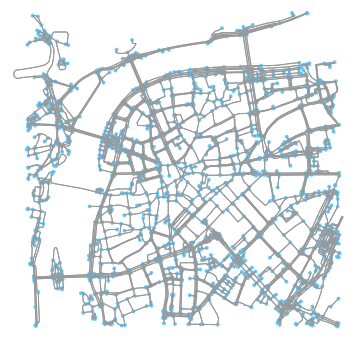

(<Figure size 706.865x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffac0ec3320>)

In [16]:
map_p = ox.graph_from_address('Prague',network_type='walk', simplify=True)
ox.plot_graph(map_p)

In [ ]:
foursquare_clien_id = 'ZL2BU5PAKUZSZZXZ115DCBVGP5Z1ESBTSL2RI3E0JL0DB4CD'
foursquare_secret = 'E00WJ4I3OFAWOFJNMMGZ1JD51N2EMW4MWZ3BKRU1IQLAWNUP'
foursquare_version = '20180605'

In [ ]:
LIMIT = 100 
radius = 2000 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    foursquare_clien_id, 
    foursquare_secret,
    foursquare_version,
    df_prague['latitude'].loc[0], 
    df_prague['longitude'].loc[0], 
    radius, 
    LIMIT,
    '4bf58dd8d48988d13b941735')

results = requests.get(url).json()